# Table of Contents:
## 1. Load features from PaulAntoine (df_train) & Fabienvs (r_train). Join them
## 2. XGB Cross Validation
## 3. XGB Train
### 3.1 Cross Validate the Threshold (in progress...)
## 4. XGB Predict
## 5. Feature Engineering

In [121]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import xgboost as xgb
IDIR = '../../features/'

# Load features from PaulAntoine (df_train) & Fabienvs (r_train). Join them.

In [122]:
# Features from r script
r_train = pd.read_csv(IDIR + 'r_train.csv').drop('Unnamed: 0', axis=1)
r_train['ord_prod_id_r'] = r_train['order_id'] * 100000 + r_train['product_id']
r_train.head()

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,...,user_distinct_products,user_average_basket,order_id,eval_set,time_since_last_order,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,reordered,ord_prod_id_r
0,1,196,10,1,10,1.400000,35791,0.582500,4.473875,0.776480,...,18,5.9,1187899,train,14,1.0,0,1.000000,1,118789900196
1,1,10258,9,2,10,3.333333,1946,0.552962,3.493716,0.713772,...,18,5.9,1187899,train,14,0.9,0,1.000000,1,118789910258
2,1,10326,1,5,5,5.000000,5526,0.521581,2.873635,0.652009,...,18,5.9,1187899,train,14,0.1,5,0.166667,0,118789910326
3,1,12427,10,1,10,3.300000,6476,0.529482,3.857058,0.740735,...,18,5.9,1187899,train,14,1.0,0,1.000000,0,118789912427
4,1,13032,3,2,10,6.333333,3751,0.479782,2.916796,0.657158,...,18,5.9,1187899,train,14,0.3,0,0.333333,1,118789913032


In [119]:
df_train = pd.read_csv(IDIR + 'df_train.csv')
df_train['ord_prod_id'] = df_train['order_id'] * 100000 + df_train['product_id']
# labels = pd.read_csv(IDIR + 'labels.csv')['0']

# f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items', \
#             'user_average_days_between_orders', 'user_average_basket', \
#             'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio', \
#             'aisle_id', 'department_id', 'product_orders', 'product_reorders', \
#             'product_reorder_rate', 'UP_orders', 'UP_orders_ratio', \
#             'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last', \
#             'UP_delta_hour_vs_last']
# df_train = df_train[f_to_use]

In [123]:
print('df_train...')
print(df_train.shape, r_train.shape)
df_train.head()

df_train...
(8474661, 23) (8474661, 25)


,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,...,product_reorders,product_reorder_rate,UP_avg_order_gap,UP_orders,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_orders_vs_last,UP_delta_hour_vs_last,ord_prod_id
0,1187899,17122,11,59,18,19.0,5.363636,8,14.0,0.736842,...,9377.0,0.675576,5.000000,1,6.0,0.090909,6,1.000000,7,-1469167166
1,1187899,196,11,59,18,19.0,5.363636,8,14.0,0.736842,...,27791.0,0.776480,0.900000,10,1.4,0.909091,1,0.100000,0,-1469184092
2,1187899,26405,11,59,18,19.0,5.363636,8,14.0,0.736842,...,536.0,0.441516,1.500000,2,5.0,0.181818,7,5.500000,1,-1469157883
3,1187899,46149,11,59,18,19.0,5.363636,8,14.0,0.736842,...,6953.0,0.812456,0.666667,3,3.0,0.272727,1,0.333333,0,-1469138139
4,1187899,14084,11,59,18,19.0,5.363636,8,14.0,0.736842,...,12923.0,0.810982,1.000000,1,2.0,0.090909,10,9.000000,0,-1469170204


In [124]:
print('Join features together...')
df_train = pd.merge(df_train, r_train, how='left', left_on='ord_prod_id', right_on='ord_prod_id_r', suffixes=('', '_r'))
del r_train
df_train.head()

Join features together...


,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,...,user_distinct_products,user_average_basket_r,order_id_r,eval_set,time_since_last_order,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,reordered,ord_prod_id_r
0,1187899,17122,11,59,18,19.0,5.363636,8,14.0,0.736842,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1187899,196,11,59,18,19.0,5.363636,8,14.0,0.736842,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1187899,26405,11,59,18,19.0,5.363636,8,14.0,0.736842,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1187899,46149,11,59,18,19.0,5.363636,8,14.0,0.736842,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1187899,14084,11,59,18,19.0,5.363636,8,14.0,0.736842,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
labels = df_train['reordered']
print('labels...')
print(labels.shape)
print('0: ', np.sum(labels == 0), '\n1: ', np.sum(labels == 1))
# 0:  7645837 
# 1:  828824
labels.head()

labels...
(8474661,)
0:  46388 
1:  5152


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: reordered, dtype: float64

In [93]:
df_train.to_csv('./all_feats.csv', index=False)
labels.to_csv('./labels_all_feats.csv', index=False)

In [94]:
print(df_train.shape)
df_train = df_train.drop(['order_id', 'product_id', 'user_id', \
                          'product_id_r', 'order_id_r', 'eval_set', \
                          'reordered', 'ord_prod_id', 'ord_prod_id_r'], axis=1)
print(df_train.shape)

(8474661, 47)
(8474661, 38)


# XGB Cross Validation

In [2]:
%%time

df_train = pd.read_csv('../../features/df_train_feats_38.csv')
order_id = df_train['order_id']
product_id = df_train['product_id']
df_train = df_train.drop(['order_id', 'product_id', 'user_id', \
                          'product_id_r', 'order_id_r', 'eval_set', \
                          'reordered', 'ord_prod_id', 'ord_prod_id_r'], axis=1)
labels = pd.read_csv('../../features/labels_feats_38.csv')
df_train.head()

,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,...,user_period,user_mean_days_since_prior,user_total_products,user_reorder_ratio,user_distinct_products,user_average_basket_r,time_since_last_order,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order
0,11,59,18,19.0,5.363636,8,14.0,0.736842,24,4,...,176,19.555556,59,0.759259,18,5.9,14,0.1,5,0.166667
1,11,59,18,19.0,5.363636,8,14.0,0.736842,77,7,...,176,19.555556,59,0.759259,18,5.9,14,1.0,0,1.000000
2,11,59,18,19.0,5.363636,8,14.0,0.736842,54,17,...,176,19.555556,59,0.759259,18,5.9,14,0.2,6,0.200000
3,11,59,18,19.0,5.363636,8,14.0,0.736842,121,14,...,176,19.555556,59,0.759259,18,5.9,14,0.3,0,0.333333
4,11,59,18,19.0,5.363636,8,14.0,0.736842,45,19,...,176,19.555556,59,0.759259,18,5.9,14,0.1,0,1.000000


In [3]:
%%time

print('formating for xgb')
d_train = xgb.DMatrix(df_train, label = labels)

formating for xgb
CPU times: user 11.3 s, sys: 6.38 s, total: 17.7 s
Wall time: 19.8 s


In [4]:
# eta = [0.1]
params = {
  "objective"           : "reg:logistic",
  "eval_metric"         : "logloss",
  "eta"                 : 0.2,
  "max_depth"           : 6,
  "min_child_weight"    : 10,
  "gamma"               : 0.70,
  "subsample"           : 0.76,
  "colsample_bytree"    : 0.95,
  "alpha"               : 2e-05,
  "lambda"              : 10
}
ROUNDS = 200

In [5]:
%%time
xgb_cv = xgb.cv(params, \
                d_train, \
                ROUNDS, \
                nfold = 3, \
                stratified = True, \
                metrics = 'logloss', \
                early_stopping_rounds = 10, \
                verbose_eval = 10)

xgb_cv.tail()

[0]	train-logloss:0.57466+8.60233e-06	test-logloss:0.57467+2.00721e-05
[10]	train-logloss:0.313568+6.2361e-06	test-logloss:0.313675+4.38254e-05
[20]	train-logloss:0.303917+2.78209e-05	test-logloss:0.304137+3.09121e-05
[30]	train-logloss:0.303201+1.50628e-05	test-logloss:0.303551+5.3897e-05
[40]	train-logloss:0.302919+1.47271e-05	test-logloss:0.303397+5.26392e-05
[50]	train-logloss:0.302687+3.0663e-05	test-logloss:0.303281+4.04228e-05
[60]	train-logloss:0.302477+1.2083e-05	test-logloss:0.303187+2.77969e-05
[70]	train-logloss:0.302296+1.22293e-05	test-logloss:0.303109+2.10132e-05
[80]	train-logloss:0.302134+1.64384e-05	test-logloss:0.303059+1.38804e-05
[90]	train-logloss:0.30198+9.74109e-06	test-logloss:0.303017+1.62138e-05
[100]	train-logloss:0.301829+7.78888e-06	test-logloss:0.302974+1.65193e-05
[110]	train-logloss:0.301687+1.13137e-05	test-logloss:0.302937+9.62635e-06
[120]	train-logloss:0.30155+7.58654e-06	test-logloss:0.302902+1.92007e-05
[130]	train-logloss:0.30142+1.07083e-05	test

In [6]:
xgb_cv.tail()

,test-logloss-mean,test-logloss-std,train-logloss-mean,train-logloss-std
195,0.302740,0.000015,0.300600,0.000007
196,0.302738,0.000017,0.300587,0.000007
197,0.302738,0.000016,0.300574,0.000007
198,0.302738,0.000018,0.300565,0.000009
199,0.302737,0.000018,0.300553,0.000010


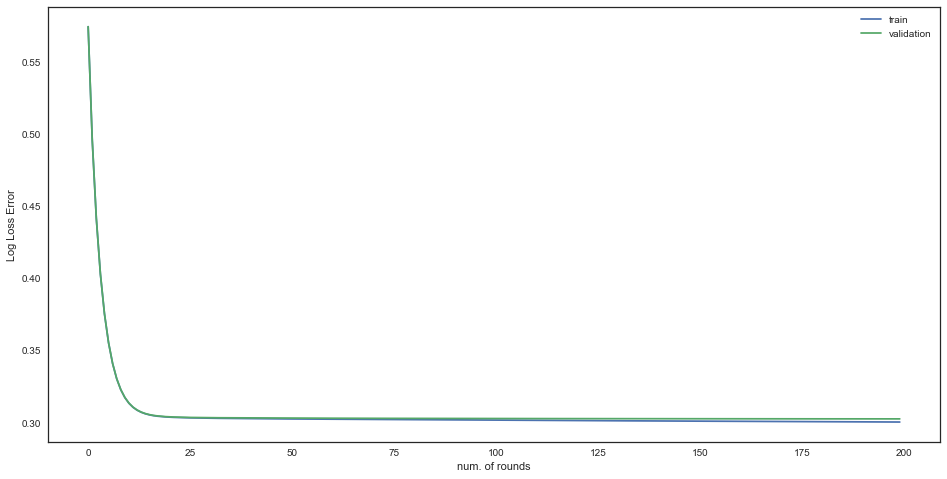

In [7]:
plt.figure(figsize=(16,8))
plt.plot(xgb_cv['train-logloss-mean'], label='train')
plt.plot(xgb_cv['test-logloss-mean'], label='validation')
# plt.xlim(200, 400)
# plt.ylim(0.3, 0.38)
plt.xlabel('num. of rounds')
plt.ylabel('Log Loss Error')
plt.legend()
plt.show()

# XGB Train

In [95]:
# eta = [0.1]
params = {
  "objective"           : "reg:logistic",
  "eval_metric"         : "logloss",
  "eta"                 : 0.2,
  "max_depth"           : 6,
  "min_child_weight"    : 10,
  "gamma"               : 0.70,
  "subsample"           : 0.76,
  "colsample_bytree"    : 0.95,
  "alpha"               : 2e-05,
  "lambda"              : 10
}
ROUNDS = 100

In [96]:
print('XGB train...')
skf = StratifiedKFold(n_splits = 5, random_state=None, shuffle=False)
fold_count = 0
for train_index, val_index in skf.split(df_train, labels):
    X_train, X_val = df_train.iloc[train_index, :], df_train.iloc[val_index, :]
    y_train, y_val = labels[train_index], labels[val_index]

    print('formating for xgb')
    d_train = xgb.DMatrix(X_train, label = y_train)
    d_valid = xgb.DMatrix(X_val, label = y_val)
    watchlist = [(d_train, 'train'), (d_valid, 'val')]

    print('Training...')
    bst = xgb.train(params = params, \
                    dtrain = d_train, \
                    num_boost_round = ROUNDS, \
                    evals = watchlist, \
                    verbose_eval = 10, \
                    early_stopping_rounds = 20)
    d_val = xgb.DMatrix(X_val)
    pred_val = pd.DataFrame(bst.predict(d_val))
#     pred_val.to_csv('./xgb_train_fold_{}.csv'.format(fold_count))
#     pd.DataFrame(y_val).to_csv('./y_val_fold_{}.csv'.format(fold_count))
    fold_count += 1
    break
    
# Stopping. Best iteration:
# [74]	train-logloss:0.243847	val-logloss:0.246293

# [90]	train-logloss:0.243247	val-logloss:0.244176

XGB train...
formating for xgb
Training...
[0]	train-logloss:0.565173	val-logloss:0.565184
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.264549	val-logloss:0.264407
[20]	train-logloss:0.246935	val-logloss:0.246803
[30]	train-logloss:0.245222	val-logloss:0.245255
[40]	train-logloss:0.244644	val-logloss:0.244838
[50]	train-logloss:0.244259	val-logloss:0.244635
[60]	train-logloss:0.243952	val-logloss:0.244455
[70]	train-logloss:0.243697	val-logloss:0.244325
[80]	train-logloss:0.243493	val-logloss:0.24427
[90]	train-logloss:0.243247	val-logloss:0.244176


In [98]:
# Save XGB model.
stamp = ''
for i, item in enumerate(list(params.values())):
    if i <= 1:
        continue
    else:
        stamp += '_' + str(item)
print(stamp)
bst.save_model('xgb{}_feats38'.format(stamp))

_0.2_6_10_0.7_0.76_0.95_2e-05_10


## Cross Validate the threshold

In [124]:
del df_train_raw, X_train_raw, X_val_raw, y_true, y_true_0, y_true_1

In [27]:
df_train_raw = pd.read_csv(IDIR + 'df_train.csv')
X_train_raw, X_val_raw = df_train_raw.iloc[train_index, :], df_train_raw.iloc[val_index, :]
X_val_raw.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,...,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last
0,1187899,17122,11,59,18,19.0,5.363636,8,14.0,0.736842,...,4,13880,9377.0,0.675576,1,0.090909,6.000000,0.090909,6,7
1,1187899,196,11,59,18,19.0,5.363636,8,14.0,0.736842,...,7,35791,27791.0,0.776480,10,0.909091,1.400000,0.909091,1,0
2,1187899,26405,11,59,18,19.0,5.363636,8,14.0,0.736842,...,17,1214,536.0,0.441516,2,0.181818,5.000000,0.181818,7,1
3,1187899,13032,11,59,18,19.0,5.363636,8,14.0,0.736842,...,14,3751,2465.0,0.657158,3,0.272727,6.333333,0.272727,1,0
4,1187899,39657,11,59,18,19.0,5.363636,8,14.0,0.736842,...,19,5019,3846.0,0.766288,1,0.090909,3.000000,0.090909,1,0


In [104]:
y_true = pd.concat([X_val_raw, y_val], axis=1)[['order_id', 'product_id', '0']]
y_true.rename(columns={'0': 'reordered'}, inplace=True)
print(y_true.shape)
y_true_0 = y_true[y_true.reordered == 0]
y_true_1 = y_true[y_true.reordered == 1]
print(y_true_1.shape)
y_true_1 = y_true_1.groupby('order_id')['product_id'].apply(list)
print(y_true_1.shape)
y_true_1.head()

(847467, 3)
(82883, 3)
(12300,)


order_id
96                    [40706, 24489, 27966, 20574, 39275]
988                                                [4818]
1042    [24852, 23094, 28985, 10814, 35140, 16083, 33000]
1275                                               [6046]
1865                                              [33129]
Name: product_id, dtype: object

In [108]:
y_true_1 = pd.DataFrame(y_true_1)

In [117]:
y_true_1.sort_index().tail()

,product_id
order_id,
3420158,"[39507, 19348]"
3420578,"[42625, 37250, 790, 43565, 33041, 20114, 47766..."
3420798,[45004]
3420909,"[28204, 25146, 5194, 24184, 21137, 4957, 35221..."
3420996,"[2086, 45066, 14947, 24852, 27423, 12125, 24035]"


In [118]:
y_pred.sort_index().tail()

,0
3420158,39507 19348
3420578,3594 24852 47766 22935 15290 45066 34789 24184
3420798,45004
3420909,30233 25146 26177 24184 35221 21938 43961 4500...
3420996,14870 45066 16965 14947 14992 24852 27423 3413...


In [85]:
# Cross_Val to tune the threshold here.
df_val = X_val_raw
df_val['pred'] = pred_val
TRESHOLD = 0.22  # guess, should be tuned with crossval on a subset of train data
d = dict()
for row in df_val.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

y_pred = pd.DataFrame.from_dict(d, orient='index')
print(y_pred.shape)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(12509, 1)


In [119]:
f1_score(y_true, pred_val)

ValueError: Can't handle mix of multiclass-multioutput and continuous

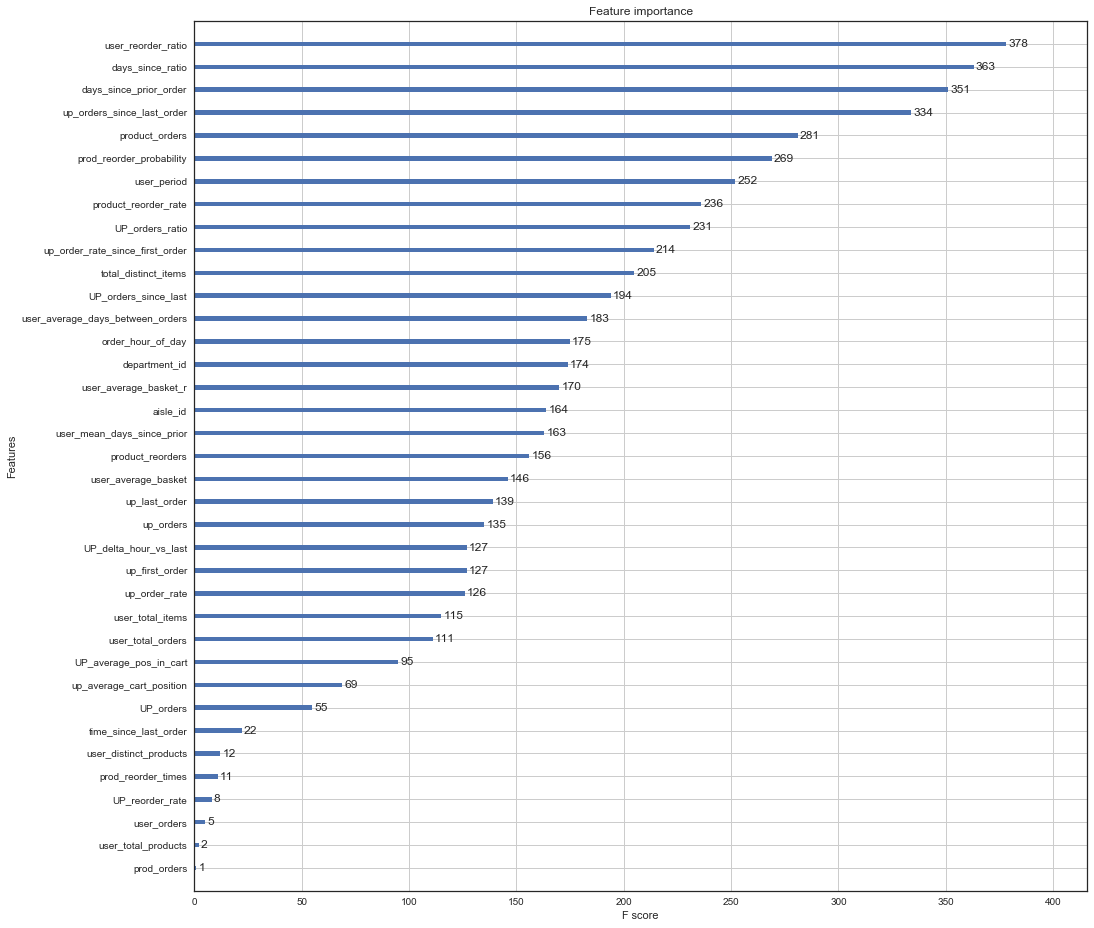

In [17]:
plt.rcParams["figure.figsize"] = (16, 16)
xgb.plot_importance(bst)

# XGB Predict

In [3]:
# Directly load joined data.

r_test = pd.read_csv(IDIR + 'r_test.csv').drop('Unnamed: 0', axis=1)
r_test['ord_prod_id_r'] = r_test['order_id'] * 100000 + r_test['product_id']
df_test = pd.read_csv(IDIR + 'df_test.csv')
df_test['ord_prod_id'] = df_test['order_id'] * 100000 + df_test['product_id']
print('Loading dataframes...')
print(r_test.shape, df_test.shape)
df_test.head()

Loading dataframes...
(4833292, 25) (4833292, 22)


,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,...,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last,ord_prod_id
0,2774568,17668,13,88,33,12.0,6.769231,15,11.0,0.916667,...,2110,1220.0,0.578199,5,0.384615,3.60,0.384615,2,3,277456817668
1,2774568,39190,13,88,33,12.0,6.769231,15,11.0,0.916667,...,10972,6294.0,0.573642,10,0.769231,1.80,0.769231,1,0,277456839190
2,2774568,44683,13,88,33,12.0,6.769231,15,11.0,0.916667,...,22275,11981.0,0.537868,2,0.153846,9.50,0.153846,7,1,277456844683
3,2774568,21903,13,88,33,12.0,6.769231,15,11.0,0.916667,...,241921,186884.0,0.772500,8,0.615385,4.25,0.615385,1,0,277456821903
4,2774568,14992,13,88,33,12.0,6.769231,15,11.0,0.916667,...,29069,16942.0,0.582820,2,0.153846,7.00,0.153846,6,0,277456814992


In [4]:
print('Join features together...')
df_test_raw = pd.merge(df_test, r_test, how='left', left_on='ord_prod_id', right_on='ord_prod_id_r', suffixes=('', '_r'))
df_test_raw.to_csv('./test_all_feats.csv', index=False)
print(df_test_raw.shape)
del r_test

df_test = df_test_raw.drop(['order_id', 'product_id', 'user_id', \
                          'product_id_r', 'order_id_r', 'eval_set', \
                          'reordered', 'ord_prod_id', 'ord_prod_id_r'], axis=1)
print(df_test.shape)

Join features together...
(4833292, 47)
(4833292, 38)


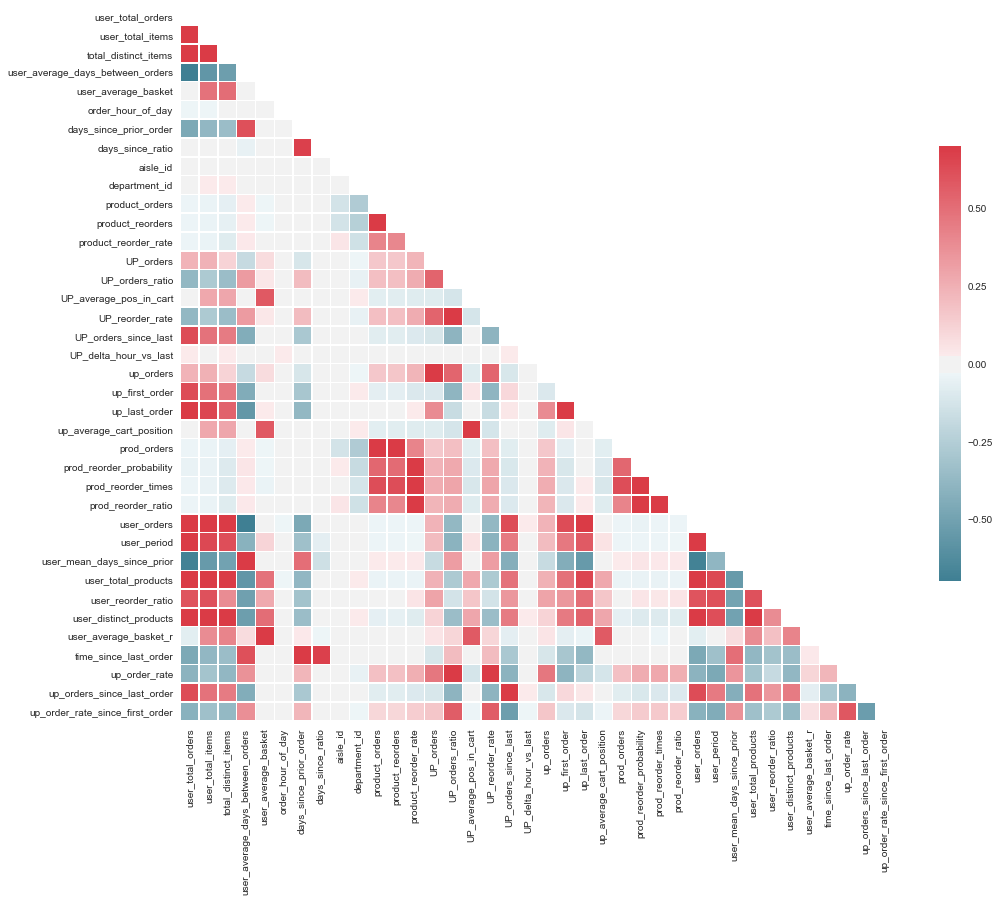

In [5]:
# Compute the correlation matrix
corr = df_test.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [6]:
# Load Model
bst = xgb.Booster()
bst.load_model('./models/xgb_0.2_6_10_0.7_0.76_0.95_2e-05_10_feats38')

In [7]:
pred = pd.DataFrame(bst.predict(xgb.DMatrix(df_test)))
pred.head()

,0
0,0.312925
1,0.734517
2,0.074725
3,0.662380
4,0.083194


In [8]:
df_test['order_id'] = df_test_raw['order_id']
df_test['product_id'] = df_test_raw['product_id']
del df_test_raw

In [17]:
df_test['pred'] = pred
TRESHOLD = 0.20
# Guess, should be tuned with crossval on a subset of train data
# [0.21=0.22:0.3803346 || 0.25:0.3753030 || 0.19:0.3808674 || 0.15:0.3742407 || 0.17:0.3787476]
# [0.15, 0.17, 0.19, 0.21, 0.22, 0.25]
# [0.3742407, 0.3787476, 0.3808674, 0.3803346, 0.3803346, 0.3753030]

d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

# Get test_orders with order_id
orders = pd.read_csv('../../data/orders.csv')
test_orders = orders[orders.eval_set == 'test']
del orders

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

del test_orders

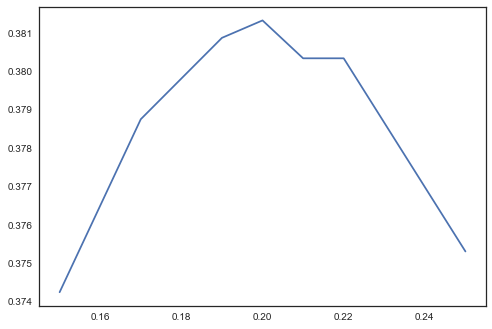

In [21]:
x_ = [0.15, 0.17, 0.19, 0.20, 0.21, 0.22, 0.25]
y_ = [0.3742407, 0.3787476, 0.3808674, 0.3813217, 0.3803346, 0.3803346, 0.3753030]
plt.plot(x_, y_)

In [18]:
sub = pd.DataFrame.from_dict(d, orient='index')
print(sub.shape)
sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub.csv', index=False)

(75000, 1)


In [19]:
sub.head()

,order_id,products
0,2774568,17668 39190 21903 47766 18599 43961 23650
1,1528013,38293 21903
2,1376945,33572 17706 28465 27959 30563 44632 24799 3465...
3,1356845,11520 14992 7076 13176 28134 10863
4,2161313,11266 196 10441 12427 37710 48142 14715 27839


# Feature Engineering

In [2]:
IDIR = '../../data/'
print('loading prior')
priors = pd.read_csv(IDIR + 'order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading train')
train = pd.read_csv(IDIR + 'order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading orders')
orders = pd.read_csv(IDIR + 'orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

print('loading products')
products = pd.read_csv(IDIR + 'products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'aisle_id', 'department_id'])

print('priors {}: {}'.format(priors.shape, ', '.join(priors.columns)))
print('train {}: {}'.format(train.shape, ', '.join(train.columns)))
print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))
print('products {}: {}'.format(products.shape, ', '.join(products.columns)))

loading prior
loading train
loading orders
loading products
priors (32434489, 4): order_id, product_id, add_to_cart_order, reordered
train (1384617, 4): order_id, product_id, add_to_cart_order, reordered
orders (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
products (49688, 3): product_id, aisle_id, department_id


In [3]:
print('computing product f')
prods = pd.DataFrame()
prods['orders'] = priors.groupby(priors.product_id).size().astype(np.int32) # No. of items of each product_id group. How many times this item has been ordered.
prods['reorders'] = priors.groupby('product_id')['reordered'].sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)
del prods

products.head()

computing product f


,product_id,aisle_id,department_id,orders,reorders,reorder_rate
product_id,,,,,,
1,1,61,19,1852.0,1136.0,0.613391
2,2,104,13,90.0,12.0,0.133333
3,3,94,7,277.0,203.0,0.732852
4,4,38,1,329.0,147.0,0.446809
5,5,5,13,15.0,9.0,0.600000


In [4]:
print('add order info to priors')
orders.set_index('order_id', inplace=True, drop=False)

# Adding cols. from orders to priors, will make duplicates on each order_id
priors = priors.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)
priors.head()

add order info to priors


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [33]:
### user related features ###

print('computing user f')
users = pd.DataFrame()
users['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
users['nb_orders'] = orders.groupby('user_id').size().astype(np.int16) # orders data gives user_id, order_id
users['total_items'] = priors.groupby('user_id').size().astype(np.int16) # priors data gives order_id, product_id
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users['all_products'].map(len)).astype(np.int16)
users['average_basket'] = (users['total_items'] / users['nb_orders']).astype(np.float32)
print('user f', users.shape)
users.head()

computing user f
user f (206209, 6)


,average_days_between_orders,nb_orders,total_items,all_products,total_distinct_items,average_basket
user_id,,,,,,
1,19.000000,11,59,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",18,5.363636
2,16.285715,15,195,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",102,13.000000
3,12.000000,13,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33,6.769231
4,17.000000,6,18,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",17,3.000000
5,11.500000,5,37,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",23,7.400000


In [6]:
### userXproduct features ###

print('compute userXproduct f - this is long...')
priors['user_product'] = priors.product_id + priors.user_id * 100000
priors.head()

compute userXproduct f - this is long...


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_product
0,2,33120,1,1,202279,prior,3,5,9,8.0,-1246903360
1,2,28985,2,1,202279,prior,3,5,9,8.0,-1246907495
2,2,9327,3,0,202279,prior,3,5,9,8.0,-1246927153
3,2,45918,4,1,202279,prior,3,5,9,8.0,-1246890562
4,2,30035,5,0,202279,prior,3,5,9,8.0,-1246906445


In [7]:
print(priors.shape, len(priors['user_product'].unique()))
print(13293564 / 32434489)
priors[['order_number', 'order_id', 'user_id', 'product_id', 'user_product']].head()

(32434489, 11) 13293564
0.40985890050556983


,order_number,order_id,user_id,product_id,user_product
0,3,2,202279,33120,-1246903360
1,3,2,202279,28985,-1246907495
2,3,2,202279,9327,-1246927153
3,3,2,202279,45918,-1246890562
4,3,2,202279,30035,-1246906445


In [61]:
#############################################################
### Just testing and visualizing how this dictionary work ###

temp = priors[priors['user_product'] == -1246903360]
d = dict()
for row in temp.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1, \
                (row.order_number, row.order_id), \
                row.add_to_cart_order, \
                [row.order_number])
    else:
        d[z] = (d[z][0] + 1, \
                max(d[z][1], (row.order_number, row.order_id)), \
                d[z][2] + row.add_to_cart_order, \
                sorted(d[z][3] + [row.order_number]))
print(d)

def get_avg_interval(list_):
    for i, item in enumerate(list_):
        if i == 0:
            diff = 0
            diff = item - 1
            last = item
        else:
            diff = diff + (item - last)
            last = item
    return diff / (i+1)

print(get_avg_interval(d[-1246903360][3]))
temp[['user_product', 'order_number', 'order_id', 'user_id', 'product_id', 'add_to_cart_order']].head()

### Just testing and visualizing how this dictionary work ###
#############################################################

{-1246903360: (5, (8, 104690), 10, [1, 3, 5, 6, 8])}
1.4


,user_product,order_number,order_id,user_id,product_id,add_to_cart_order
0,-1246903360,3,2,202279,33120,1
990781,-1246903360,8,104690,202279,33120,2
1254949,-1246903360,6,132412,202279,33120,1
26635932,-1246903360,5,2808715,202279,33120,1
27453973,-1246903360,1,2894949,202279,33120,5


In [14]:
%%time

# For each (user_id , product_id) pair, 
## count number of occurences of this pair
## get the latest order_id from max(order_number, order_id). Note: order_id is not sequential, order_number is.
## accumulate all add_to_cart_order

d = dict()
for row in priors.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1, \
                (row.order_number, row.order_id), \
                row.add_to_cart_order, \
                [row.order_number])
    else:
        d[z] = (d[z][0] + 1, \
                max(d[z][1], (row.order_number, row.order_id)), \
                d[z][2] + row.add_to_cart_order, \
                sorted(d[z][3] + [row.order_number]))
print('to dataframe (less memory)')
userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d
userXproduct.head()

to dataframe (less memory)
CPU times: user 6min 32s, sys: 6.7 s, total: 6min 38s
Wall time: 6min 39s


In [26]:
def get_avg_interval(list_):
    if len(list_) == 1:
        return list_[0]
    for i, item in enumerate(list_):
        if i == 0:
            diff = 0
            last = item
        else:
            diff = diff + (item - last)
            last = item
    return diff / (i+1)

userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart', 'order_num_list']
userXproduct['nb_orders'] = userXproduct['nb_orders'].astype(np.int16)
userXproduct['last_order_id'] = userXproduct['last_order_id'].map(lambda x: x[1]).astype(np.int32)
userXproduct['sum_pos_in_cart'] = userXproduct['sum_pos_in_cart'].astype(np.int16)
userXproduct['avg_order_gap'] = userXproduct['order_num_list'].map(get_avg_interval)

print('user X product f', len(userXproduct))
userXproduct.head(20)

user X product f 13293564


,nb_orders,last_order_id,sum_pos_in_cart,order_num_list,avg_order_gap
-1246903360,5,104690,10,"[1, 3, 5, 6, 8]",1.400000
-1246907495,5,132412,16,"[1, 2, 3, 5, 6]",1.000000
-1246927153,1,2,3,[3],3.000000
-1246890562,5,2382766,24,"[2, 3, 5, 6, 7]",1.000000
-1246906445,3,2382766,14,"[3, 5, 7]",1.333333
-1246918686,7,2382766,25,"[1, 2, 3, 4, 5, 6, 7]",0.857143
-1246896339,5,132412,29,"[2, 3, 4, 5, 6]",0.800000
-1246934661,2,2,19,"[2, 3]",0.500000
-1246892812,3,132412,20,"[3, 5, 6]",1.000000
-877802726,17,368699,86,"[1, 3, 4, 5, 6, 9, 10, 11, 14, 15, 16, 18, 20,...",1.411765


#### Note:
#### 1. Feature DataFrames: products, users, userXproduct
#### 2. DataFrames: train, orders, priors

In [29]:
### train / test orders ###
print('split orders : train, test')
train_orders = orders[orders.eval_set == 'train']
# test_orders = orders[orders.eval_set == 'test']
# prior_orders = orders[orders.eval_set == 'prior']

train.set_index(['order_id', 'product_id'], inplace=True, drop=False)
# priors.set_index(['order_id', 'product_id'], inplace=True, drop=False)

split orders : train, test


In [30]:
train_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,,
1187899,1187899,1,train,11,4,8,14.0
1492625,1492625,2,train,15,1,11,30.0
2196797,2196797,5,train,5,0,11,6.0
525192,525192,7,train,21,2,11,6.0
880375,880375,8,train,4,1,14,10.0


In [65]:
### Build list of candidate products to reorder, with features ###

def features(selected_orders, labels_given=False):
    ''' Builds (order_id, product_id) pairs. 
    The order_id is repeated until all associated product_id is looped through. 
    Every order_id has several associated product_id & a unique user_id. '''

    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i += 1
        if i%10000 == 0: print('order row:', i, '/', len(selected_orders))
        order_id = row.order_id
        user_id = row.user_id
        # users df contains all user_id; selected_orders df contains part of the user_id
        user_products = users.all_products[user_id] # The index of users df is the user_id. All products the user ordered.
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in train.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    print('order related features')
    # df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_avg_order_gap'] = df.z.map(userXproduct.avg_order_gap)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number) # User total orders - UxP.order_id.order_number
    df['UP_delta_orders_vs_last'] = df['UP_orders_since_last'] - df['UP_avg_order_gap']
    
    # (Current_order_hour_of_day) - (Last_order_hour_of_day). The time of day diff between current_order & last_order.
    ## i.e. Last time this product was ordered at 3PM by this user, this time it's ordered at 4PM, so 1 hour apart.
    ## The closer the hours, the smaller this feature, higher probability it will be re-ordered.
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)) \
                                                                      .map(lambda x: min(x, 24-x)).astype(np.int8)
    
    # df['UP_same_dow_as_last_order'] = df.UP_last_order_id.map(orders.order_dow) == \
    #                                                                      df.order_id.map(orders.order_dow)

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)

In [60]:
%%time

# df_train, labels = features(train_orders, labels_given=True)

selected_orders = train_orders
labels_given = True
print('build candidate list')
order_list = []
product_list = []
labels = []
i=0
for row in selected_orders.itertuples():
    i += 1
    if i%10000 == 0: print('order row:', i, '/', len(selected_orders))
    order_id = row.order_id
    user_id = row.user_id
    # users df contains all user_id; selected_orders df contains part of the user_id
    user_products = users.all_products[user_id] # The index of users df is the user_id. All products the user ordered.
    product_list += user_products
    order_list += [order_id] * len(user_products)
    if labels_given:
        labels += [(order_id, product) in train.index for product in user_products]

df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
labels = np.array(labels, dtype=np.int8)
del order_list
del product_list

build candidate list
order row: 10000 / 131209
order row: 20000 / 131209
order row: 30000 / 131209
order row: 40000 / 131209
order row: 50000 / 131209
order row: 60000 / 131209
order row: 70000 / 131209
order row: 80000 / 131209
order row: 90000 / 131209
order row: 100000 / 131209
order row: 110000 / 131209
order row: 120000 / 131209
order row: 130000 / 131209
CPU times: user 2h 27min 33s, sys: 1min 13s, total: 2h 28min 46s
Wall time: 2h 30min 23s


In [66]:
print('user related features')
df['user_id'] = df.order_id.map(orders.user_id)
df['user_total_orders'] = df.user_id.map(users.nb_orders)
df['user_total_items'] = df.user_id.map(users.total_items)
df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
df['user_average_basket'] =  df.user_id.map(users.average_basket)

print('order related features')
df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders

print('product related features')
df['aisle_id'] = df.product_id.map(products.aisle_id)
df['department_id'] = df.product_id.map(products.department_id)
df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
df['product_reorders'] = df.product_id.map(products.reorders)
df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

print('user_X_product related features')
df['z'] = df.user_id * 100000 + df.product_id
df.drop(['user_id'], axis=1, inplace=True)
df['UP_avg_order_gap'] = df.z.map(userXproduct.avg_order_gap)
df['UP_orders'] = df.z.map(userXproduct.nb_orders)
df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number) # User total orders - UxP.order_id.order_number
df['UP_delta_orders_vs_last'] = df['UP_orders_since_last'] - df['UP_avg_order_gap']

# (Current_order_hour_of_day) - (Last_order_hour_of_day). The time of day diff between current_order & last_order.
## i.e. Last time this product was ordered at 3PM by this user, this time it's ordered at 4PM, so 1 hour apart.
## The closer the hours, the smaller this feature, higher probability it will be re-ordered.
df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)) \
                                                                  .map(lambda x: min(x, 24-x)).astype(np.int8)

# df['UP_same_dow_as_last_order'] = df.UP_last_order_id.map(orders.order_dow) == \
#                                                                      df.order_id.map(orders.order_dow)

df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
print(df.dtypes)
print(df.memory_usage())

user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_id                               int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              uint8
department_id                         uint8
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_avg_order_gap                    float64
UP_orders                             int16
UP_average_pos_in_cart              float32
UP_reorder_rate                     float32
UP_orders_since_la

In [86]:
print(8474661 / 131209)
print(df.shape, selected_orders.shape, labels.shape)
df.head()

64.58902209452096
(8474661, 22) (131209, 7) (8474661,)


,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,...,product_orders,product_reorders,product_reorder_rate,UP_avg_order_gap,UP_orders,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_orders_vs_last,UP_delta_hour_vs_last
0,1187899,17122,11,59,18,19.0,5.363636,8,14.0,0.736842,...,13880,9377.0,0.675576,5.000000,1,6.0,0.090909,6,1.000000,7
1,1187899,196,11,59,18,19.0,5.363636,8,14.0,0.736842,...,35791,27791.0,0.776480,0.900000,10,1.4,0.909091,1,0.100000,0
2,1187899,26405,11,59,18,19.0,5.363636,8,14.0,0.736842,...,1214,536.0,0.441516,1.500000,2,5.0,0.181818,7,5.500000,1
3,1187899,46149,11,59,18,19.0,5.363636,8,14.0,0.736842,...,8558,6953.0,0.812456,0.666667,3,3.0,0.272727,1,0.333333,0
4,1187899,14084,11,59,18,19.0,5.363636,8,14.0,0.736842,...,15935,12923.0,0.810982,1.000000,1,2.0,0.090909,10,9.000000,0


In [74]:
df.to_csv('./df_train_interval.csv', index=False)
pd.DataFrame(labels).to_csv('./labels_train_interval.csv', index=False) # No labels for test set.

In [ ]:
df['labels'] = labels

9.22492229955


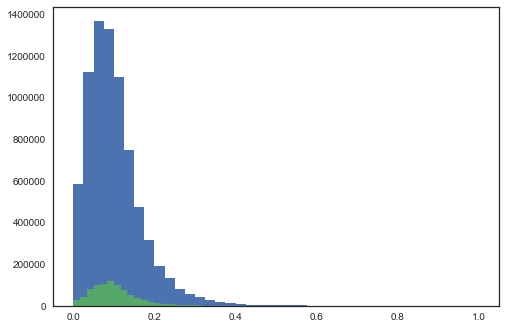

In [117]:
# Plotting to see predictability of the feature.

H1 = df[df['labels'] == 1]['days_since_ratio']
newH1 = H1[~np.isnan(H1)]
norm1 = np.apply_along_axis(func1d=lambda x: x/np.max(newH1), arr=newH1, axis=0)

H0 = df[df['labels'] == 0]['days_since_ratio']
newH0 = H0[~np.isnan(H0)]
norm0 = np.apply_along_axis(func1d=lambda x: x/np.max(newH0), arr=newH0, axis=0)

print(np.sum([df['labels'] == 0]) / np.sum([df['labels'] == 1]))
_ = plt.hist(norm0, bins=40)
_ = plt.hist(norm1, bins=60)

In [118]:
df = df.drop('labels', axis=1)
df.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,...,product_orders,product_reorders,product_reorder_rate,UP_avg_order_gap,UP_orders,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_orders_vs_last,UP_delta_hour_vs_last
0,1187899,17122,11,59,18,19.0,5.363636,8,14.0,0.736842,...,13880,9377.0,0.675576,5.000000,1,6.0,0.090909,6,1.000000,7
1,1187899,196,11,59,18,19.0,5.363636,8,14.0,0.736842,...,35791,27791.0,0.776480,0.900000,10,1.4,0.909091,1,0.100000,0
2,1187899,26405,11,59,18,19.0,5.363636,8,14.0,0.736842,...,1214,536.0,0.441516,1.500000,2,5.0,0.181818,7,5.500000,1
3,1187899,46149,11,59,18,19.0,5.363636,8,14.0,0.736842,...,8558,6953.0,0.812456,0.666667,3,3.0,0.272727,1,0.333333,0
4,1187899,14084,11,59,18,19.0,5.363636,8,14.0,0.736842,...,15935,12923.0,0.810982,1.000000,1,2.0,0.090909,10,9.000000,0


In [ ]:
test_orders = orders[orders.eval_set == 'test']
df_test, _ = features(test_orders, labels_given=False)
df_test.head()